In [1]:
try:
    import pyqae as pq
except ImportError:
    import sys
    sys.path.append('/Users/mader/Dropbox/Informatics/pyqae-master')
    import pyqae as pq

from pyqae.images import viz, pull_img_http_array
import pyqae.nd as nd_array # multidimensional distributed arrays
from pyqae.sitk import show_itk_image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import SimpleITK as sitk
from glob import glob
from skimage.io import imread

(30021, 22902)


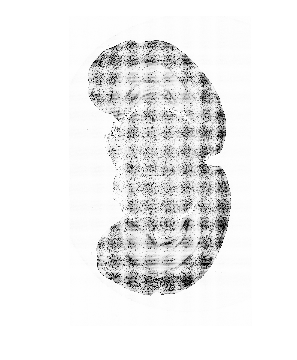

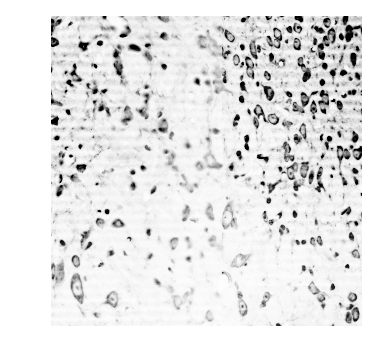

In [2]:
%matplotlib inline
brain_stack_img = imread('/Volumes/ExDisk/cor03639_CH2_ij.tif')
print(brain_stack_img.shape)
_ = viz.show_image(brain_stack_img[::10, ::10])
_ = viz.show_image(brain_stack_img[15000:16000, 10000:11000])

In [3]:
dist_brain_img = nd_array.sp_array(np.expand_dims(np.expand_dims(brain_stack_img,0),3), sc, axis = (0,))
print(dist_brain_img, dist_brain_img.shape)

BoltArray
mode: spark
shape: (1, 30021, 22902, 1)
 (1, 30021, 22902, 1)


In [4]:
from scipy.ndimage import gaussian_filter
from skimage import img_as_float
from skimage.morphology import reconstruction
from skimage.exposure import adjust_gamma

def rolling_ball_background(in_image, radius):
    # Convert to float: Important for subtraction later which won't work with uint8
    image = img_as_float(in_image)
    image = gaussian_filter(image, radius)

    seed = np.copy(image)
    seed[1:-1, 1:-1] = image.min()
    mask = image

    dilated = reconstruction(seed, mask, method='dilation')
    return image - dilated
def gamma_bg_sub(img, radius = 100, gamma = 0.2):
    return rolling_ball_background(adjust_gamma(img, gamma), radius)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.06 µs
(1502, 1146)


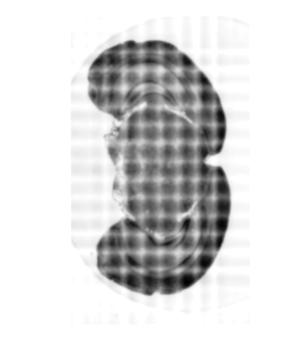

In [5]:
# test on a tiny ROI
%time
_ = viz.show_image(gamma_bg_sub(brain_stack_img[::20, ::20], radius = 5))
print(brain_stack_img[::20, ::20].shape)

In [6]:
dist_filt_img = nd_array.filt_tensor(dist_brain_img, filter_op = gamma_bg_sub, tile_size=(1500, 1000), padding = (100, 100))

In [ ]:
_ = viz.show_image(dist_filt_img[0,::20, ::20, 0].toarray())